## Introduction and Explanation

This is a detailed solution for Titanic challenge, including acquiring data, exploratory analysis, transformation, modeling and optimization.    

However, in order to meet some requirement in assignment, I copy the train and test data to dataset_mini. In other words, train_data and test_data will follow the whole machine learning recipe and perform transformation based on the result from exploratory analysis. But the train_data_mini and test_data_mini will follow the requirements in the assignment. The main difference of these dataset takes place at the transformation part. The train_data_mini and test_data_mini will only perform the minimal feature engineering.     

At the beginning of two feature engineering parts, there are summaries of transformations applied to the dataset.   
The results required by the assignment are mainly located at Modeling part and related transformations are located at corresponding Transformation sections.   

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

## Acquire data

In [2]:
# Note the use of *relative path*; your assignments should all use relative rather than absolute paths
TITANIC_PATH = "./data"

train_data = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv"), index_col = 0)
test_data  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv"), index_col = 0)

In [3]:
#Copy train_data and test_data to train_data_mini and test_data_mini 
#for minimal transformation required by assignment 
train_data_mini = train_data
test_data_mini = test_data

## Analyze by Describing Data

### Feature Information

In [4]:
train_data.columns.values

array(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

|  Variable   | Defination  |  Key   |
|  ----      | ----      | -----   |
|survival	   |Survival	|0 = No, 1 = Yes|
|pclass	     |Ticket class	|1 = upper, 2 = middle, 3 = lower|
|sex	     |Sex	      |           |
|Age	     |Age in years	|            |
|sibsp	     |# of siblings / spouses aboard the Titanic |          |	
|parch	     |# of parents / children aboard the Titanic |          |	
|ticket	     |Ticket number	|             |
|fare	     |Passenger fare|             |  	
|cabin	     |Cabin number	|             |
|embarked	   |Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton|

from: https://www.kaggle.com/c/titanic/data

In [5]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* Categorical Features: Survived, Pclass, Sex, and Pclass. 
* Numerical Features: Age, Fare, SibSp and Parch
    - Continous: Age, Fare. 
    - Discrete: SibSp, Parch.

In [6]:
train_data.info()
print('_'*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64

In training dataset, Age, Cabin, Embarked are incomplete features.    
In test dataset, Age, Fare and Cabin are incomplete features
  
Both in training and test dataset, 5 features are integer or floats.(Survibed is not a feature in training dataset but a target)  
and 5 features are strings (object).

### Outlier

In [7]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

In [8]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_data,2,["Age","SibSp","Parch","Fare"])

train_data.loc[Outliers_to_drop] # Show the outliers rows

# Drop outliers
train_data = train_data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

C:\Users\bmy31\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S


This detection function draws heavily from https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling, using Tukey method to detect outliers, which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have two (in this case) feature value outside the (IQR +- an outlier step).

We detect outliers from numerical features (Age, SibSp, Sarch and Fare). Then, We outliers as rows that have at least two outlied numerical features.We detect 10 outliers. The 28, 89 and 342 passenger have an high Ticket Fare. The 7 others have very high values of SibSP.

Note: the outlier detection is only applied to train_data rather than train_data_mini because of the assignmeng requirement. The following exploratory analysis is based on train_data, which has already eliminated the impact of outliers. 

### Data Description

In [9]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [10]:
train_data['Parch'].quantile([.75, .8])
print('_'*40)
train_data['SibSp'].quantile([.68, .69])
print('_'*40)
train_data['Age'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])
print('_'*40)
train_data['Fare'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])
print('_'*40)

0.75    0.0
0.80    1.0
Name: Parch, dtype: float64

________________________________________


0.68    0.0
0.69    0.2
Name: SibSp, dtype: float64

________________________________________


0.10    14.0
0.20    19.0
0.30    22.0
0.40    25.0
0.50    28.0
0.60    32.0
0.70    36.0
0.80    41.0
0.90    50.0
0.99    65.9
Name: Age, dtype: float64

________________________________________


0.10      7.5500
0.20      7.8542
0.30      8.0500
0.40     10.5000
0.50     14.4542
0.60     21.0000
0.70     26.5500
0.80     39.0000
0.90     77.2875
0.99    227.5250
Name: Fare, dtype: float64

________________________________________


From data desrcribing, we find
- Total samples in training dataset are 891 and around 38% samples survived.
- Most passengers (around 75%) did not travel with parents or children.
- Nearly 70% of the passengers had siblings and/or spouse aboard.
- Around 40% of the passengers are in twenties and less then 1% passangers are over 65. 
- Fares varied significantly with few passengers (<1%), with highest value $512.

In [11]:
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,881,881,881,201,879
unique,881,2,680,147,3
top,"Lefebre, Miss. Ida",male,1601,G6,S
freq,1,572,7,4,634


From describing catogorical features, we find  
- Names are unique across the dataset (count=unique=891)
- Sex variable as two possible values with 65%(577/891) male.
- Ticket feature has 24%(1- 681/891) of duplicate values.
- Cabin values have several dupicates across samples, which means several passagers will share one cabin.
- Embarked takes three possible values. 72% passagers(644/891) embarked from Southampton.


## Analyze Correlation by Visualization

### Correlation with Category Features

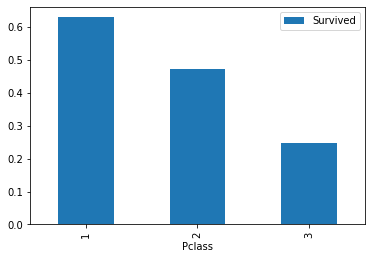

In [12]:
# Explore Pclass vs Survived 
(train_data[['Pclass', 'Survived']].groupby(['Pclass']).mean()).plot(kind = 'bar')

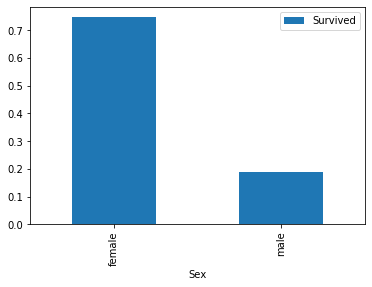

In [13]:
# Explore Sex vs Survived 
(train_data[["Sex", "Survived"]].groupby(['Sex']).mean()).plot(kind = 'bar')

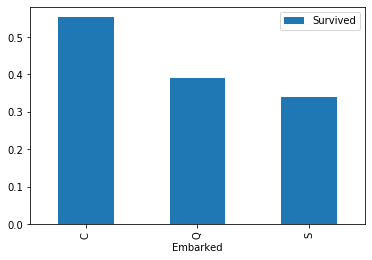

In [14]:
# Explore Embarked vs Survived 
(train_data[["Embarked", "Survived"]].groupby(['Embarked']).mean()).plot(kind = 'bar')

- **Pclass** We observe significant correlation among Pclass and Survived. Passagers with higher location class(smaller Pclass value) are more likely to survive. We decide to include this feature in our model.
- **Sex** Female had very high survival rate at 74%.
- **Embarked** There is a significant correlation among Embarked and Survived. Passagers embarked at Southampton are more likely to survive. We will include this feature in our model

### Correlation with Numerical Features

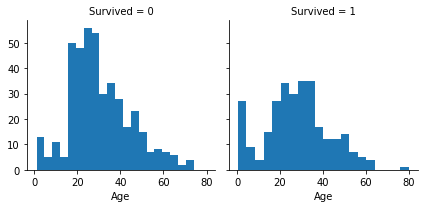

In [15]:
# Explore Age vs Survived 
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

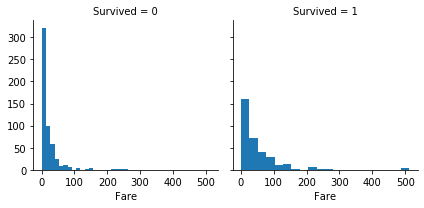

In [16]:
# Explore Fare vs Survived 
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Fare', bins=20)

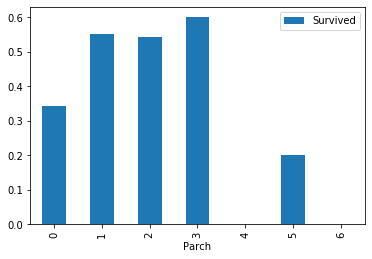

In [17]:
# Explore Parch vs Survived 
(train_data[["Parch", "Survived"]].groupby(['Parch']).mean()).plot(kind = 'bar')

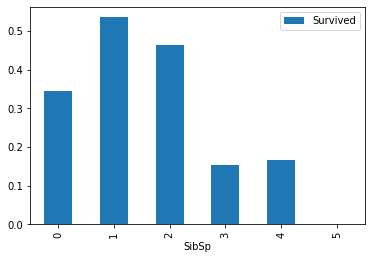

In [18]:
# Explore SibSp vs Survived 
(train_data[["SibSp", "Survived"]].groupby(['SibSp']).mean()).plot(kind = 'bar')

- **Age** We find infants (Age <=4) had high survival rate and a large number of 15-25 year olds did not survive. We will include Age in our model. When we dive further, we can find there are obvious subgroups within age distribution vs Survived. For Survived = 0, most passagers are 16-28, fewer passagers are 28-40, and 40-56 and there are quite fewer 0-16, 56-80 passagers. For Survived = 1, there is a similar pattern. So it gives me an idea to divide age into 5 buckets.
- **Fare** As we can see, Fare distributions in both Survived and Not Survived set are very skewed. This can lead to overweigth very high values in the model, even if it is scaled. In this case, it is better to transform it with the log function to reduce this skew.  
- **SibSp and Parch** These features don't have a direct correlation or apparent relationship with Survived. It may be better to derive a feature or a set of features from these individual features.

### Correlation with Numerical and Category Features

C:\Users\bmy31\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


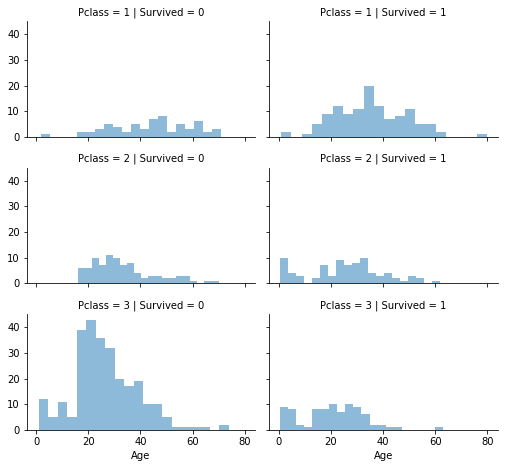

In [19]:
# Explore Age vs Survived by Pclass
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

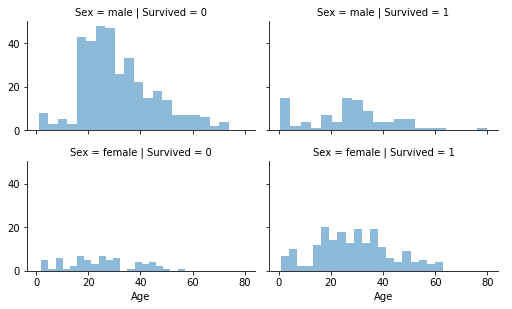

In [20]:
# Explore Age vs Survived by Sex
grid = sns.FacetGrid(train_data, col='Survived', row='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

C:\Users\bmy31\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


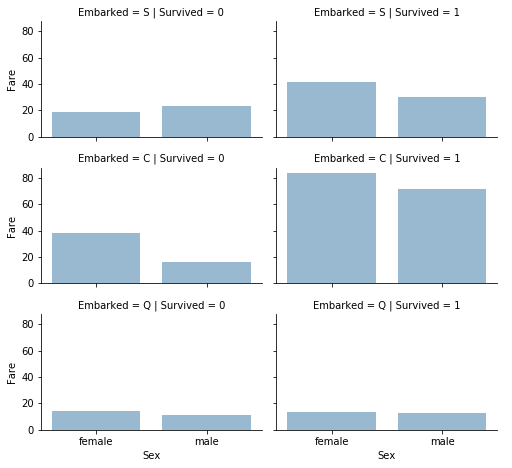

In [21]:
# Explore Fare vs Survived by Embarked
grid = sns.FacetGrid(train_data, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

- **Age and Pclass** Surviving situtations of Pclass varies in terms of Age distribution of passengers. Especially, infant passengers in Pclass=2 and Pclass=3 mostly survived.
- **Age and Sex** A large number of 15-30 years old males didn't survived and infant males are more likely to survive compared with adults men.
- **Fare and Embarked** Higher fare paying passengers had better survival.Port of embarkation correlates with survival rates. We will consider banding Fare feature.

### Correlation with Multiple Category Features

C:\Users\bmy31\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\bmy31\Anaconda3\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


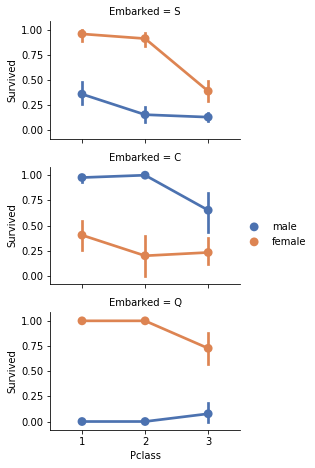

In [22]:
# Explore Pclass vs Survived by Embarked and Sex
grid = sns.FacetGrid(train_data, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

- **Pclass, Embark and Sex** Passagers embarked at different port share similar surviving rate distribution in terms of Sex and Pclass. Passagers who is female and in Pclass 1 or 2 are more likely to survive 

## Minimal Transformation for Assignment Requirement

According to the requirement in the assignment, train_data_mini and test_data_mini only deal with missing features, transform categorical features drop non-numeric features. The train_data_mini and test_data_mini will be used in the Naive Bayes model (base model) and Logistic Regression model with minimal feature engineering.    

- Deal with missing features
   - fill numerical features (Fare, Age) with the median value in the train dataset
   - drop the features with too missing vlues. (Ticket, Cabin)
   - fill the categorical feature (Embarked) with the most frequent value. 
- Drop feature
   - drop Name because models can not handle strings without preprocess. 
- Categorical Transformations
   - applied to Embarked and Sex. 
   - In the Modeling part, I will use the default logistic regression in sklearn including a regularied cost function, which will not fall in dummy variable trap.

Age bucketing (equal spaced buckets and equal quantile buckets)is also included in this part. But the bucketing features derived from Age will not included in the Naive Bayes model (base model) and Logistic Regression model with minimal feature engineering. It is preparation for the third part of the assignment (Perform feature engineering and create another Logistic Regression classifier).   

### Dealing with Missing Features

In [23]:
#Fill Fare and Age missing values with the median value in training set
train_data_mini["Fare"] = train_data_mini["Fare"].fillna(train_data_mini["Fare"].median())
test_data_mini["Fare"] = test_data_mini["Fare"].fillna(train_data_mini["Fare"].median())

train_data_mini["Age"] = train_data_mini["Age"].fillna(train_data_mini["Age"].median())
test_data_mini["Age"] = test_data_mini["Age"].fillna(train_data_mini["Age"].median())

#Fill Embarked nan values of dataset set with 'S' most frequent value
train_data_mini["Embarked"] = train_data_mini["Embarked"].fillna("S")
test_data_mini["Embarked"] = test_data_mini["Embarked"].fillna("S")

In [24]:
#Drop Features missing too much values [Ticket, Cabin] 
#Drop Name because models cannot handle with string feature without preprocess
train_data_mini = train_data_mini.drop(['Ticket', 'Cabin', 'Name'], axis=1)
test_data_mini = test_data_mini.drop(['Ticket', 'Cabin', 'Name'], axis=1)

### Categorical Transformations

In [25]:
#Transform Categorical Features [Embarked, Sex]
train_data_mini = pd.get_dummies(train_data_mini, columns = ["Embarked"], prefix="Em")
train_data_mini = pd.get_dummies(train_data_mini, columns = ["Sex"])

test_data_mini = pd.get_dummies(test_data_mini, columns = ["Embarked"], prefix="Em")
test_data_mini = pd.get_dummies(test_data_mini, columns = ["Sex"])

### Age Bucket

According to the analysis of Age distribution in Visualization Analysis part, I will divide Age into 5 Buckets.

#### Equal Spaced Buckets

In [26]:
train_data_mini['AgeBandV1'] = pd.cut(train_data_mini['Age'], 5)
train_data_mini[['AgeBandV1', 'Survived']].groupby(['AgeBandV1']).mean()
train_data_mini = train_data_mini.drop(['AgeBandV1'], axis=1)

,Survived
AgeBandV1,
"(0.34, 16.336]",0.550000
"(16.336, 32.252]",0.344168
"(32.252, 48.168]",0.404255
"(48.168, 64.084]",0.434783
"(64.084, 80.0]",0.090909


In [27]:
combine = [train_data_mini, test_data_mini]
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'AgeV1'] = (0+16)/2
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'AgeV1'] = (16+32)/2
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'AgeV1'] = (32+48)/2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'AgeV1'] = (48+64)/2
    dataset.loc[ dataset['Age'] > 64, 'AgeV1'] = (64+80)/2
train_data_mini.head()
test_data_mini.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S,Sex_female,Sex_male,AgeV1
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,0,1,0,1,24.0
2,1,1,38.0,1,0,71.2833,1,0,0,1,0,40.0
3,1,3,26.0,0,0,7.9250,0,0,1,1,0,24.0
4,1,1,35.0,1,0,53.1000,0,0,1,1,0,40.0
5,0,3,35.0,0,0,8.0500,0,0,1,0,1,40.0


,Pclass,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S,Sex_female,Sex_male,AgeV1
PassengerId,,,,,,,,,,,
892,3,34.5,0,0,7.8292,0,1,0,0,1,40.0
893,3,47.0,1,0,7.0000,0,0,1,1,0,40.0
894,2,62.0,0,0,9.6875,0,1,0,0,1,56.0
895,3,27.0,0,0,8.6625,0,0,1,0,1,24.0
896,3,22.0,1,1,12.2875,0,0,1,1,0,24.0


#### Equal Quantile Buckets

In [28]:
train_data_mini['AgeBandV2'] = pd.qcut(train_data_mini['Age'], 5, duplicates= 'drop')
train_data_mini[['AgeBandV2', 'Survived']].groupby(['AgeBandV2']).mean()
train_data_mini = train_data_mini.drop(['AgeBandV2'], axis=1)

,Survived
AgeBandV2,
"(0.419, 20.0]",0.458101
"(20.0, 28.0]",0.327778
"(28.0, 38.0]",0.434286
"(38.0, 80.0]",0.372881


When using the quantile cut, there is a duplicate edges, which retults in few bins. 

In [29]:
combine = [train_data_mini, test_data_mini]
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 20, 'AgeV2'] = (0+20)/2
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 28), 'AgeV2'] = (20+28)/2
    dataset.loc[(dataset['Age'] > 28) & (dataset['Age'] <= 38), 'AgeV2'] = (28+38)/2
    dataset.loc[ dataset['Age'] > 38, 'AgeV2'] = (38+80)/2
train_data_mini.head()
test_data_mini.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S,Sex_female,Sex_male,AgeV1,AgeV2
PassengerId,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,0,1,0,1,24.0,24.0
2,1,1,38.0,1,0,71.2833,1,0,0,1,0,40.0,33.0
3,1,3,26.0,0,0,7.9250,0,0,1,1,0,24.0,24.0
4,1,1,35.0,1,0,53.1000,0,0,1,1,0,40.0,33.0
5,0,3,35.0,0,0,8.0500,0,0,1,0,1,40.0,33.0


,Pclass,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S,Sex_female,Sex_male,AgeV1,AgeV2
PassengerId,,,,,,,,,,,,
892,3,34.5,0,0,7.8292,0,1,0,0,1,40.0,33.0
893,3,47.0,1,0,7.0000,0,0,1,1,0,40.0,59.0
894,2,62.0,0,0,9.6875,0,1,0,0,1,56.0,59.0
895,3,27.0,0,0,8.6625,0,0,1,0,1,24.0,24.0
896,3,22.0,1,1,12.2875,0,0,1,1,0,24.0,24.0


## Transformation

For train_data and test_data, I use more transformations, including outlier detection in previous part, dealing with missing features, creating new features, categorical transformation, Age bucket, normality and dropping features. The train_data and test_data will be used in extra points part in assignment. 

- Outlier detection
   - Use Tukey method to detect outliers

- Deal with missing features 
   - Fill Fare missing values with the median value in training set
   - Fill Age with the median age of similar rows in training dataset according to Pclass, Parch and SibSp by exploratory analysis
   - Fill Embarked with most frequent value
    
- Create new features
   - Get Title from Name
   - Create new feature of family size and bucket it into Single, SmallF(small family size), MedF(medium family size), LargeF(large family size)

- Categorical transformation
   - Apply transformation into Title, EMbarked and Sex

- Age bucket
   - Equal spaced buckets and equal quantile buckets

- Normality
   - Transform Fare with the log function to reduce skew

- Drop features
   - Drop Ticket, Cabin, Parch, SibSp (the information is included in the familysize buckets) and Name

### Complete a numerical feature

In [30]:
#Fill Fare missing values with the median value in training set
train_data["Fare"] = train_data["Fare"].fillna(train_data["Fare"].median())
test_data["Fare"] = test_data["Fare"].fillna(train_data["Fare"].median())

C:\Users\bmy31\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\bmy31\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\bmy31\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.wa

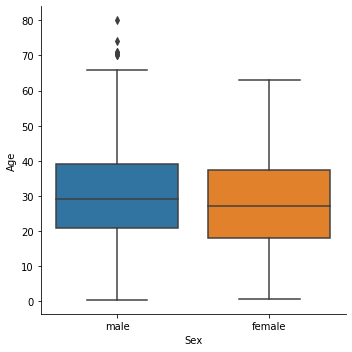

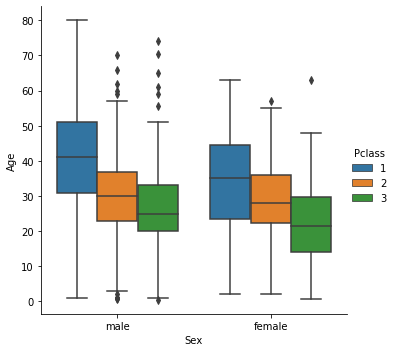

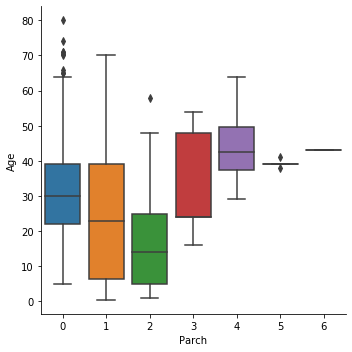

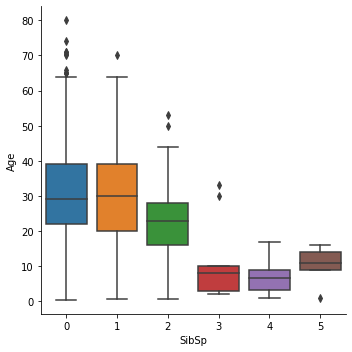

In [31]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=train_data,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=train_data,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=train_data,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=train_data,kind="box")

In [32]:
# Filling missing value of Age 

## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train_data)
dataset =  pd.concat(objs=[train_data, test_data], axis=0).reset_index(drop=True)

## Fill Age with the median age of similar rows in training dataset according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = train_data["Age"].median()
    age_pred = train_data["Age"][((train_data['SibSp'] == dataset.iloc[i]["SibSp"]) & (train_data['Parch'] == dataset.iloc[i]["Parch"]) & (train_data['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med
        
## Separate train dataset and test dataset
train_data = dataset[:train_len]
test_data = dataset[train_len:]

C:\Users\bmy31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """
C:\Users\bmy31\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Age distribution seems to be the same in the Male and Female, which means Sex may not contribute to predict Age. However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers. What's more, Age distributions within different Parch and SibSp are quite different. So use Pclass, Parch and SibSp to predict missing values of Age.

### Complete a categorical feature

In [33]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
train_data["Embarked"] = train_data["Embarked"].fillna("S")
test_data["Embarked"] = test_data["Embarked"].fillna("S")

C:\Users\bmy31\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\bmy31\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Create New Features

#### Title from Name

In [34]:
# Get Title from Name
combine = [train_data, test_data]

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_data['Title'], train_data['Sex'])

# We can replace many titles with a more common name or classify them as Rare.
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,39


Survived
Sex    Title           
female Miss    0.711111
       Mrs     0.793651
       Rare    1.000000
male   Master  0.589744
       Mr      0.157895
       Rare    0.250000

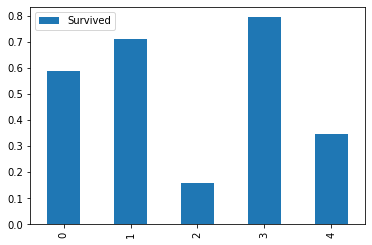

In [35]:
train_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().plot(kind='bar')
train_data[['Title', 'Survived']].groupby([train_data["Sex"],train_data["Title"]], as_index=True).mean()

Title is one of the most common feature added during feature engineering. It shows there are great differences among passengers with different titles. For example, passagers with Mr title has quite low surviving rate compared with passagers with Miss title. However, this kind of difference may resulted from Sex. When we look into Miss and Mrs groups, which are both female group, the difference of surviving rate is not significant enough. So the information given by title may overlap with the one from sex. However, for males, passagers with Maaster title are more likly to survive compared with ones with Mr title. In other words, Title seperate female and male passagers into subgroup, especially for male passagers, which may help improve model prediction.

#### family size

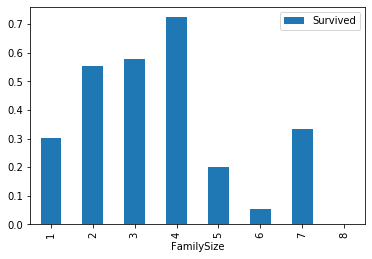

In [36]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

(train_data[['FamilySize', 'Survived']].groupby(['FamilySize']).mean()).plot(kind='bar')

In [37]:
# Create new feature of family size
combine = [train_data, test_data]
for dataset in combine:
    dataset['Single'] = dataset['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    dataset['SmallF'] = dataset['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
    dataset['MedF'] = dataset['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    dataset['LargeF'] = dataset['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

C:\Users\bmy31\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


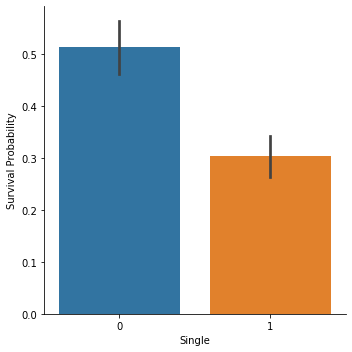

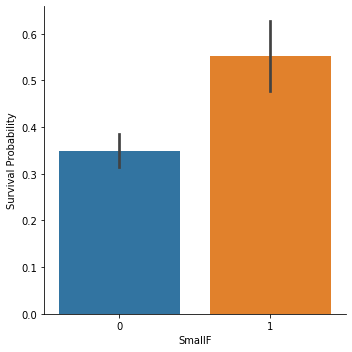

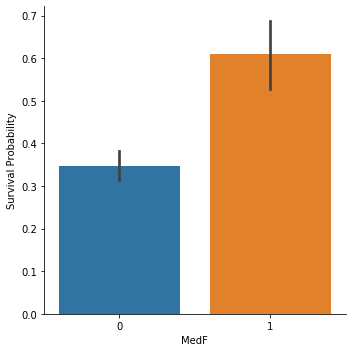

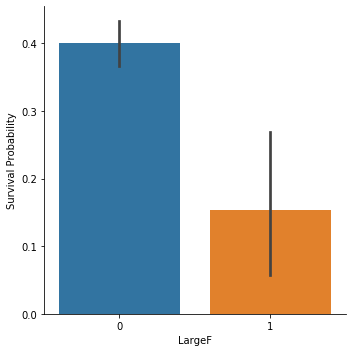

In [38]:
g = sns.factorplot(x="Single",y="Survived",data=train_data,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=train_data,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=train_data,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=train_data,kind="bar")
g = g.set_ylabels("Survival Probability")

### Categorical Transformation

In [39]:
train_data = pd.get_dummies(train_data, columns = ["Title"])
train_data = pd.get_dummies(train_data, columns = ["Embarked"], prefix="Em")
train_data = pd.get_dummies(train_data, columns = ["Sex"])

test_data = pd.get_dummies(test_data, columns = ["Title"])
test_data = pd.get_dummies(test_data, columns = ["Embarked"], prefix="Em")
test_data = pd.get_dummies(test_data, columns = ["Sex"])

In [40]:
train_data.head()
test_data.head()

,Age,Cabin,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket,FamilySize,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S,Sex_female,Sex_male
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,3,1,0.0,A/5 21171,2,...,0,0,1,0,0,0,0,1,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,1,1.0,PC 17599,2,...,0,0,0,1,0,1,0,0,1,0
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,1,...,0,1,0,0,0,0,0,1,1,0
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,1,1.0,113803,2,...,0,0,0,1,0,0,0,1,1,0
4,35.0,NaN,8.0500,"Allen, Mr. William Henry",0,3,0,0.0,373450,1,...,0,0,1,0,0,0,0,1,0,1


,Age,Cabin,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket,FamilySize,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S,Sex_female,Sex_male
881,34.5,NaN,7.8292,"Kelly, Mr. James",0,3,0,NaN,330911,1,...,0,0,1,0,0,0,1,0,0,1
882,47.0,NaN,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,3,1,NaN,363272,2,...,0,0,0,1,0,0,0,1,1,0
883,62.0,NaN,9.6875,"Myles, Mr. Thomas Francis",0,2,0,NaN,240276,1,...,0,0,1,0,0,0,1,0,0,1
884,27.0,NaN,8.6625,"Wirz, Mr. Albert",0,3,0,NaN,315154,1,...,0,0,1,0,0,0,0,1,0,1
885,22.0,NaN,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,3,1,NaN,3101298,3,...,0,0,0,1,0,0,0,1,1,0


Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

### Age Bucket 

#### Equal Spaced Buckets

In [41]:
train_data['AgeBandV1'] = pd.cut(train_data['Age'], 5)
train_data[['AgeBandV1', 'Survived']].groupby(['AgeBandV1']).mean()
train_data = train_data.drop(['AgeBandV1'], axis=1)

,Survived
AgeBandV1,
"(0.34, 16.336]",0.518868
"(16.336, 32.252]",0.343816
"(32.252, 48.168]",0.412844
"(48.168, 64.084]",0.434783
"(64.084, 80.0]",0.090909


In [42]:
combine = [train_data, test_data]
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'AgeV1'] = (0+16)/2
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'AgeV1'] = (16+32)/2
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'AgeV1'] = (32+48)/2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'AgeV1'] = (48+64)/2
    dataset.loc[ dataset['Age'] > 64, 'AgeV1'] = (64+80)/2
train_data.head()
test_data.head()

,Age,Cabin,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket,FamilySize,...,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S,Sex_female,Sex_male,AgeV1
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,3,1,0.0,A/5 21171,2,...,0,1,0,0,0,0,1,0,1,24.0
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,1,1.0,PC 17599,2,...,0,0,1,0,1,0,0,1,0,40.0
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,1,...,1,0,0,0,0,0,1,1,0,24.0
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,1,1.0,113803,2,...,0,0,1,0,0,0,1,1,0,40.0
4,35.0,NaN,8.0500,"Allen, Mr. William Henry",0,3,0,0.0,373450,1,...,0,1,0,0,0,0,1,0,1,40.0


,Age,Cabin,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket,FamilySize,...,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S,Sex_female,Sex_male,AgeV1
881,34.5,NaN,7.8292,"Kelly, Mr. James",0,3,0,NaN,330911,1,...,0,1,0,0,0,1,0,0,1,40.0
882,47.0,NaN,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,3,1,NaN,363272,2,...,0,0,1,0,0,0,1,1,0,40.0
883,62.0,NaN,9.6875,"Myles, Mr. Thomas Francis",0,2,0,NaN,240276,1,...,0,1,0,0,0,1,0,0,1,56.0
884,27.0,NaN,8.6625,"Wirz, Mr. Albert",0,3,0,NaN,315154,1,...,0,1,0,0,0,0,1,0,1,24.0
885,22.0,NaN,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,3,1,NaN,3101298,3,...,0,0,1,0,0,0,1,1,0,24.0


#### Equal Quantile Buckets

In [43]:
train_data['AgeBandV2'] = pd.qcut(train_data['Age'], 5, duplicates= 'drop')
train_data[['AgeBandV2', 'Survived']].groupby(['AgeBandV2']).mean()
train_data = train_data.drop(['AgeBandV2'], axis=1)

,Survived
AgeBandV2,
"(0.419, 20.0]",0.454545
"(20.0, 26.0]",0.298450
"(26.0, 30.0]",0.400000
"(30.0, 39.0]",0.442623
"(39.0, 80.0]",0.374233


When using the quantile cut, there is a duplicate edges, which retults in few bins. 

In [44]:
combine = [train_data, test_data]
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 20, 'AgeV2'] = (0+20)/2
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 28), 'AgeV2'] = (20+28)/2
    dataset.loc[(dataset['Age'] > 28) & (dataset['Age'] <= 38), 'AgeV2'] = (28+38)/2
    dataset.loc[ dataset['Age'] > 38, 'AgeV2'] = (38+80)/2
train_data.head()
test_data.head()

,Age,Cabin,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket,FamilySize,...,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S,Sex_female,Sex_male,AgeV1,AgeV2
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,3,1,0.0,A/5 21171,2,...,1,0,0,0,0,1,0,1,24.0,24.0
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,1,1.0,PC 17599,2,...,0,1,0,1,0,0,1,0,40.0,33.0
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,1,...,0,0,0,0,0,1,1,0,24.0,24.0
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,1,1.0,113803,2,...,0,1,0,0,0,1,1,0,40.0,33.0
4,35.0,NaN,8.0500,"Allen, Mr. William Henry",0,3,0,0.0,373450,1,...,1,0,0,0,0,1,0,1,40.0,33.0


,Age,Cabin,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket,FamilySize,...,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S,Sex_female,Sex_male,AgeV1,AgeV2
881,34.5,NaN,7.8292,"Kelly, Mr. James",0,3,0,NaN,330911,1,...,1,0,0,0,1,0,0,1,40.0,33.0
882,47.0,NaN,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,3,1,NaN,363272,2,...,0,1,0,0,0,1,1,0,40.0,59.0
883,62.0,NaN,9.6875,"Myles, Mr. Thomas Francis",0,2,0,NaN,240276,1,...,1,0,0,0,1,0,0,1,56.0,59.0
884,27.0,NaN,8.6625,"Wirz, Mr. Albert",0,3,0,NaN,315154,1,...,1,0,0,0,0,1,0,1,24.0,24.0
885,22.0,NaN,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,3,1,NaN,3101298,3,...,0,1,0,0,0,1,1,0,24.0,24.0


### Normality

In [45]:
# Apply log to Fare to reduce skewness distribution
train_data["Fare"] = train_data["Fare"].map(lambda i: np.log(i+1) if i+1 > 0 else 0)
test_data["Fare"] = test_data["Fare"].map(lambda i: np.log(i+1) if i+1 > 0 else 0)

### Drop Features

In [46]:
train_data = train_data.drop(['Ticket', 'Cabin'], axis=1)
test_data = test_data.drop(['Ticket', 'Cabin'], axis=1)

train_data = train_data.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_data = test_data.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

train_data.head()

,Age,Fare,Pclass,Survived,Single,SmallF,MedF,LargeF,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S,Sex_female,Sex_male,AgeV1,AgeV2
0,22.0,2.110213,3,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,24.0,24.0
1,38.0,4.280593,1,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,40.0,33.0
2,26.0,2.188856,3,1.0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,24.0,24.0
3,35.0,3.990834,1,1.0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,40.0,33.0
4,35.0,2.202765,3,0.0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,40.0,33.0


Based on pervious analysis, we drop the Cabin and Ticket features.

## Modeling

### Data Separation and Preparation for Different Models

In [47]:
#Set a random state
random_state = 2

#Separation
Y_train_mini = train_data_mini["Survived"].astype(int)
X_train_mini = train_data_mini.drop(labels = ["Survived"],axis = 1)
X_test_mini = test_data_mini

#Preparation for different models
Age_train = X_train_mini['Age']
AgeV1_train = X_train_mini['AgeV1']
AgeV2_train = X_train_mini['AgeV2']

Age_test = X_test_mini['Age']
AgeV1_test = X_test_mini['AgeV1']
AgeV2_test = X_test_mini['AgeV2']

X_train_mini = X_train_mini.drop(labels = ["Age","AgeV1","AgeV2"],axis = 1)
X_test_mini = X_test_mini.drop(labels = ["Age","AgeV1","AgeV2"],axis = 1)
X_train_mini.columns
X_test_mini.columns

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Em_C', 'Em_Q', 'Em_S',
       'Sex_female', 'Sex_male'],
      dtype='object')

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Em_C', 'Em_Q', 'Em_S',
       'Sex_female', 'Sex_male'],
      dtype='object')

### A Simple Model Using Naive Bayes

In [48]:
X_train_mini['Age'] = Age_train
X_test_mini['Age'] = Age_test
X_train_mini.columns
X_test_mini.columns

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Em_C', 'Em_Q', 'Em_S',
       'Sex_female', 'Sex_male', 'Age'],
      dtype='object')

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Em_C', 'Em_Q', 'Em_S',
       'Sex_female', 'Sex_male', 'Age'],
      dtype='object')

In [49]:
gnb = GaussianNB().fit(X_train_mini, Y_train_mini)

accuracy_gnb = cross_val_score(gnb, X_train_mini, Y_train_mini, scoring = 'accuracy',cv=5)

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [50]:
model = "Naive Bayes"
cross_val_avg = accuracy_gnb.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=model, sc=cross_val_avg) )

accuracy = accuracy_gnb.mean()
print("{m:s}: Accuracy = {a:.2%}".format(m=model, a=accuracy) )

Naive Bayes: Avg cross val score = 0.79
Naive Bayes: Accuracy = 78.90%


### Logistic Regression

In [51]:
X_train_mini.columns
X_test_mini.columns

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Em_C', 'Em_Q', 'Em_S',
       'Sex_female', 'Sex_male', 'Age'],
      dtype='object')

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Em_C', 'Em_Q', 'Em_S',
       'Sex_female', 'Sex_male', 'Age'],
      dtype='object')

In [52]:
logr = LogisticRegression(random_state = random_state,solver = 'liblinear').fit(X_train_mini, Y_train_mini)
accuracy_logr = cross_val_score(logr, X_train_mini, Y_train_mini, scoring = 'accuracy',cv=5)

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [53]:
model = "Logistic Regression, version 0"
cross_val_avg = accuracy_logr.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=model, sc=cross_val_avg) )

accuracy = accuracy_logr.mean()
print("{m:s}: Accuracy = {a:.2%}".format(m=model, a=accuracy) )


Logistic Regression, version 0: Avg cross val score = 0.79
Logistic Regression, version 0: Accuracy = 78.79%


### Logistic Regression with Age Bucket

#### Equal Spaced Buckets

In [54]:
X_train_mini = X_train_mini.drop(labels = ["Age"],axis = 1)
X_test_mini = X_test_mini.drop(labels = ["Age"],axis = 1)
X_train_mini['AgeV1'] = AgeV1_train
X_test_mini['AgeV1'] = AgeV1_test
X_train_mini.columns
X_test_mini.columns

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Em_C', 'Em_Q', 'Em_S',
       'Sex_female', 'Sex_male', 'AgeV1'],
      dtype='object')

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Em_C', 'Em_Q', 'Em_S',
       'Sex_female', 'Sex_male', 'AgeV1'],
      dtype='object')

In [55]:
logr1 = LogisticRegression(random_state = random_state,solver = 'liblinear').fit(X_train_mini, Y_train_mini)
accuracy_linr1 = cross_val_score(logr1, X_train_mini, Y_train_mini, scoring = 'accuracy',cv=5)

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [56]:
model = "Logistic Regression, bucketing version 1"
cross_val_avg = accuracy_linr1.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=model, sc=cross_val_avg) )

accuracy = accuracy_linr1.mean()
print("{m:s}: Accuracy = {a:.2%}".format(m=model, a=accuracy) )


Logistic Regression, bucketing version 1: Avg cross val score = 0.79
Logistic Regression, bucketing version 1: Accuracy = 78.79%


#### Equal Quantile Buckets

In [57]:
X_train_mini = X_train_mini.drop(labels = ["AgeV1"],axis = 1)
X_test_mini = X_test_mini.drop(labels = ["AgeV1"],axis = 1)
X_train_mini['AgeV2'] = AgeV2_train
X_test_mini['AgeV2'] = AgeV2_test
X_train_mini.columns
X_test_mini.columns

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Em_C', 'Em_Q', 'Em_S',
       'Sex_female', 'Sex_male', 'AgeV2'],
      dtype='object')

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Em_C', 'Em_Q', 'Em_S',
       'Sex_female', 'Sex_male', 'AgeV2'],
      dtype='object')

In [58]:
logr2 = LogisticRegression(random_state = random_state, solver = 'liblinear').fit(X_train_mini, Y_train_mini)
accuracy_linr2 = cross_val_score(logr2, X_train_mini, Y_train_mini, scoring = 'accuracy',cv=5)

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [59]:
model = "Logistic Regression, bucketing version 2"
cross_val_avg = accuracy_linr2.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=model, sc=cross_val_avg) )

accuracy = accuracy_linr2.mean()
print("{m:s}: Accuracy = {a:.2%}".format(m=model, a=accuracy) )


Logistic Regression, bucketing version 2: Avg cross val score = 0.79
Logistic Regression, bucketing version 2: Accuracy = 79.24%


According to the mean value of cross validation scores, Equal quantile buckets have a little bit higher R^2 and accuracy.  

### Another Logistic Regression with More Feature Engineering

In [60]:
#Separation
Y_train = train_data["Survived"].astype(int)
X_train = train_data.drop(labels = ["Survived"],axis = 1)

X_test = test_data.drop(labels = ["Survived"],axis = 1)

In [61]:
X_train.columns
X_test.columns

Index(['Age', 'Fare', 'Pclass', 'Single', 'SmallF', 'MedF', 'LargeF',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
       'Em_C', 'Em_Q', 'Em_S', 'Sex_female', 'Sex_male', 'AgeV1', 'AgeV2'],
      dtype='object')

Index(['Age', 'Fare', 'Pclass', 'Single', 'SmallF', 'MedF', 'LargeF',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
       'Em_C', 'Em_Q', 'Em_S', 'Sex_female', 'Sex_male', 'AgeV1', 'AgeV2'],
      dtype='object')

To begin with, I use a random forest model to analysis the feature importance. To some extent, it can help to verify some assumptions from exploratory analysis.

In [62]:
#Feature importance analysis with random forest
forest = RandomForestClassifier(random_state=random_state).fit(X_train, Y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, list(X_train.columns.values)[indices[f]], importances[indices[f]]))

Feature ranking:
1. Fare (0.232330)
2. Age (0.179709)
3. Sex_female (0.145834)
4. Title_Mr (0.071895)
5. Pclass (0.071605)
6. Sex_male (0.052361)
7. AgeV2 (0.037737)
8. AgeV1 (0.032698)
9. Title_Miss (0.028171)
10. LargeF (0.025988)
11. MedF (0.019850)
12. Single (0.018907)
13. Title_Mrs (0.017836)
14. Em_C (0.015312)
15. Title_Master (0.013551)
16. Em_S (0.013086)
17. SmallF (0.011034)
18. Em_Q (0.009875)
19. Title_Rare (0.002223)


C:\Users\bmy31\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


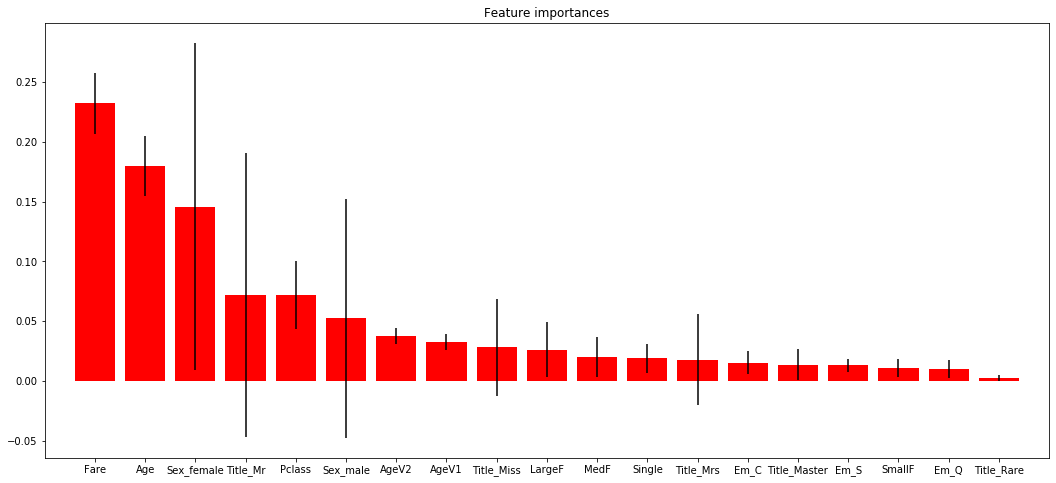

In [63]:
# Plot the feature importances of the forest
_ = plt.figure(figsize=(18,8))
_ = plt.title("Feature importances")
_ = plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")

# plt.xticks(range(X_train.shape[1]), indices)
_ = plt.xticks(range(X_train.shape[1]),[list(X_train.columns.values)[i] for i in indices])
_ = plt.xlim([-1, X_train.shape[1]])
plt.show()

From the feature importance analysis,
- Title does help to imporve the model by sepearting males into subgroups, because Title_Mr has higher importance than Sex_mal.
- AgeV2 and AgeV1 may not be so siginificant in the model, because Age has already provide the information. Since the relationship between Age and Survived is not linear, when I use logistic regression model, Age Bucket may help a lot. But this not hold when using more sophisticated models. So I will not include AgeV1 and AgeV2 in following modeling.
- Fare, Age Sex_female are the most important features for predicting survived.

In [64]:
X_train = X_train.drop(labels = ["AgeV1","AgeV2"],axis = 1)
X_test = X_test.drop(labels = ["AgeV1","AgeV2"],axis = 1)
X_train.columns
X_test.columns

Index(['Age', 'Fare', 'Pclass', 'Single', 'SmallF', 'MedF', 'LargeF',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
       'Em_C', 'Em_Q', 'Em_S', 'Sex_female', 'Sex_male'],
      dtype='object')

Index(['Age', 'Fare', 'Pclass', 'Single', 'SmallF', 'MedF', 'LargeF',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
       'Em_C', 'Em_Q', 'Em_S', 'Sex_female', 'Sex_male'],
      dtype='object')

In [65]:
logr3 = LogisticRegression(random_state = random_state,solver = 'liblinear').fit(X_train, Y_train)
accuracy_logr3 = cross_val_score(logr3, X_train, Y_train, scoring = 'accuracy',cv=5)

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements
- Also replace the "???" with a description of your feature engineering.

Repeat this cell for each new feature engineering/transformation that you submit.

In [66]:
title = "Title, FamilySize, Age Imputor and Outlier Detector"
cross_val_avg = accuracy_logr3.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=title, sc=cross_val_avg) )

accuracy = accuracy_logr3.mean()
print("{m:s}: Accuracy = {a:.2%}".format(m=title, a=accuracy) )

Title, FamilySize, Age Imputor and Outlier Detector: Avg cross val score = 0.82
Title, FamilySize, Age Imputor and Outlier Detector: Accuracy = 82.41%


More feature engineering helps to improve the Logistic Regression model from 79.24% accuracy(equal quantile buckets) to 82.41% accuracy.

### Simple Modeling

In [67]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))


In [68]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std, "Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

cv_res = cv_res.set_index(['Algorithm'])
cv_res.sort_values(by='CrossValMeans', ascending = False)

,CrossValMeans,CrossValerrors
Algorithm,,
LinearDiscriminantAnalysis,0.828588,0.036869
SVC,0.827477,0.044208
GradientBoosting,0.826353,0.038950
LogisticRegression,0.825204,0.042247
MultipleLayerPerceptron,0.824042,0.040176
RandomForest,0.805912,0.032256
AdaBoost,0.802541,0.038828
KNeighboors,0.793475,0.049686
ExtraTrees,0.785495,0.042815


I compared 10 popular classifiers and evaluate the mean accuracy of each of them by cross validation procedure. 

* SVC
* Decision Tree
* AdaBoost 
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis    

Reference: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling


Based on the results of simple modeling, I choose SVC, GradientBoosting, LogisticRegression, MultipleLayerPerceptron and RandomForest for hyperparameter tunning with grid search.


### Hyperparameter tunning for best models

In [69]:
# GradientBoosting
GBC = GradientBoostingClassifier(random_state = random_state)
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
bsGBC = gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   25.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_spli...
                                                  random_state=2, subsample=1.0,
                                                  tol=0.0001,
                                                  validation_fr

In [70]:
# LogisticRegression
LR = LogisticRegression(random_state = random_state)


## Search grid for optimal parameters
lr_param_grid = {"penalty": ['l1','l2'],
              "C": [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
              "class_weight": [None,'balanced']}


gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLR.fit(X_train,Y_train)

LR_best = gsLR.best_estimator_

# Best score
bsLR = gsLR.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:    0.7s finished
C:\Users\bmy31\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=2, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=4,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             

In [71]:
# MultipleLayerPerceptron
MLP = MLPClassifier(random_state = random_state)


## Search grid for optimal parameters
mlp_param_grid = {"hidden_layer_sizes": [(50,),(100,),(200,),(300,),(400,),(500,)],
              "activation": ['identity', 'logistic', 'tanh', 'relu']}


gsMLP = GridSearchCV(MLP,param_grid = mlp_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsMLP.fit(X_train,Y_train)

MLP_best = gsMLP.best_estimator_

# Best score
bsMLP = gsMLP.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   43.9s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  1.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_...
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=2, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=4,
        

In [72]:
# RandomFores
RFC = RandomForestClassifier(random_state = random_state)


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
bsRFC = gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   41.6s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   53.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fra...
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=2,
                                              verbose=0, warm_start=False),
   

In [73]:
# SVC classifier
SVMC = SVC(probability=True, random_state = random_state)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
bsSVMC = gsSVMC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   32.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=2, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=4,
             param_grid={'C': [1, 10, 50, 100, 200, 300, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [74]:
# Based on previous tunning, find out the best model
model_list = [GBC_best, LR_best, MLP_best, RFC_best, SVMC_best]
model_list[[bsGBC, bsLR, bsMLP, bsRFC, bsSVMC].index(max([bsGBC, bsLR, bsMLP, bsRFC, bsSVMC]))]

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [75]:
title = "Titanic contest"
cross_val_avg = max([bsGBC, bsLR, bsMLP, bsRFC, bsSVMC])

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=title, sc=cross_val_avg) )

accuracy = max([bsGBC, bsLR, bsMLP, bsRFC, bsSVMC])
print("{m:s}: Accuracy = {a:.2%}".format(m=title, a=accuracy) )

Titanic contest: Avg cross val score = 0.84
Titanic contest: Accuracy = 83.77%


So with the hyperparameter tunning, the best model is the random forest classifier with 83.77% cross validation score.

### Model Evaluation

In [76]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\bmy31\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

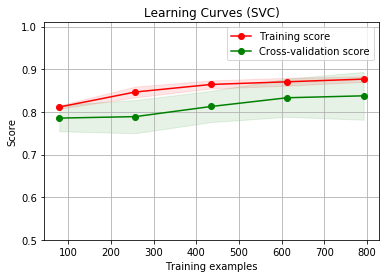

In [77]:
title = "Learning Curves (SVC)"
plot_learning_curve(RFC_best, title, X_train, Y_train, ylim=(0.5, 1.01), cv=kfold, n_jobs=4)
plt.show()

Using the plot_learning_curve from the official website of Sklearn, I draw the learning curve of trainning set. It shows, as the trainning goes on, the trainning score rises and cross-validation score converges to the trainning score. There is no obvious overfitting.